# Classification

> 1. 获取数据集
> MNIST 

 这是一组由高中生和美国人口普查局雇员手写的70,000个小图像组成的数据集。每个图像都标有它所代表的数字。

In [16]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

sklearn.datasets 包含三类主要函数：

1. fetch_* 函数：如 fetch_openml()，用于下载真实生活中的数据集。
2. load_* 函数：用于加载 Scikit-Learn 自带的小型玩具数据集，这些数据集不需要通过网络下载。
3. make_* 函数：用于生成测试时需要的虚拟数据集。

生成的数据集通常以 (X, y) 元组形式返回，包含输入数据和目标标签，二者都为 NumPy 数组。其他数据集则以 sklearn.utils.Bunch 对象返回，这是一种字典结构，条目也可以通过属性访问。通常包含以下条目：

- "DESCR"：数据集的描述。
- "data"：输入数据，通常为 2D NumPy 数组。
- "target"：标签，通常为 1D NumPy 数组。

fetch_openml() 函数稍有不同，默认情况下会将输入数据作为 Pandas DataFrame 返回，将标签作为 Pandas Series 返回（除非数据集是稀疏的）。不过，由于 MNIST 数据集包含图像，DataFrame 并不是理想的格式，因此建议设置 as_frame=False，以便以 NumPy 数组的形式获取数据。让我们来查看这些数组的结构：

In [17]:
X,y = mnist.data,mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
X.shape

(70000, 784)

In [19]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [20]:
y.shape

(70000,)

有7万张图片，每张图片有784个特征。这是因为每张图像都是28 × 28像素，每个特征仅仅表示一个像素的强度，从0（白色）到255（黑色）。让我们看一下数据集中的一个数字（图3-1）。我们所需要做的就是获取实例的特征向量，将其重塑为28 × 28数组，并使用Matplotlib的imshow（）函数显示它。我们使用cmap="binary"来获得一个灰度色图，其中0为白色，255为黑色：
![](3-1.png)

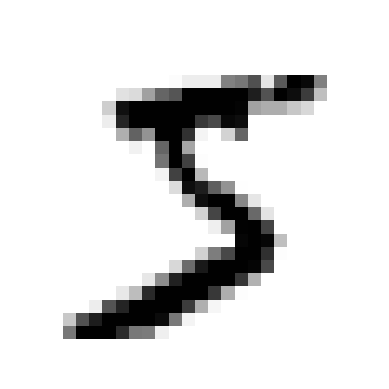

In [21]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [22]:
y[0]    #对应的标签，确实是5

'5'

当调用fetch_openml()时已经打乱了数据集的顺序，并划分了训练集和测试集，前6万张图片为训练集，后1万张图片为测试集

In [23]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

训练集已经对我们进行了洗牌，这很好，因为这保证了所有交叉验证折叠都是相似的（我们不希望有一个折叠缺少一些数字）。此外，一些学习算法对训练实例的顺序很敏感，如果连续获得许多相似的实例，它们的性能就会很差。对数据集进行洗牌可以确保不会发生这种情况

![](3-2.png)

> Training a Binary Classifier   训练一个二值分类器
> 
先由易到难，先创造一个二分类器，检测图片中的数字是5还是非5

In [24]:
y_train_5 = (y_train == '5')    #如果为5，则为True 否则为False
y_test_5 = (y_test == '5')

现在让我们选择一个分类器并训练它。一个好的起点是使用ScikitLearn的SGDClassifier类，使用随机梯度下降（SGD，或随机GD）分类器。这个分类器能够有效地处理非常大的数据集。这部分是因为SGD独立地处理训练实例，每次处理一个，这也使得SGD非常适合在线学习，正如您稍后将看到的那样。让我们创建一个SGDClassifier并在整个训练集上训练它：

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [26]:
sgd_clf.predict([some_digit])

array([ True])

## 2. Performance Measures

评估分类器通常比评估回归器要棘手得多，所以我们将在本章的大部分时间里讨论这个话题

> 1. Measuring Accuracy Using Cross-Validation  使用交叉验证测量精度

In [27]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

所有交叉验证中的准确率都在95以上，使用一个简单的分类器，只把每张图片分为最常见的类别，在这个例子中，在这个例子中最常见的类是non 5
由于数字5在数据集中仅占少数，将所有图片都分类为“非5”实际上可以获得较高的准确率，因为大多数标签本身就是非5。这说明高准确率并不一定意味着分类器有效，尤其是在不平衡的数据集上（即一种类别比另一种多得多的情况）。


In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict([X_train])))

False


In [29]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

没错，准确率超过90% ！这很简单，因为只有大约10%的图像是5，所以如果你总是猜测图像不是5，你将有90%的时间是正确的。胜占卜者。这说明了为什么准确性通常不是分类器的首选性能度量，特别是当您处理倾斜的数据集时（例如，当某些类比其他类更频繁时）。<span style="background-color:yellow">**评估分类器性能的更好方法是查看混淆矩阵（CM）**</span>。

这里有个自主实现交叉验证，见cross-validation.ipynb

> Confusion Matrices
> 
混淆矩阵的基本概念是**统计每一类实例被分类为其他类的次数**，涵盖所有类别组合。例如，要了解分类器将8误分类为0的次数，可以查看混淆矩阵的第8行、第0列。

如何计算混淆矩阵

1. 获取预测结果：需要一组预测结果以便与实际标签进行比较。尽管可以在测试集上进行预测，但最好暂时保持测试集不变（记住，你希望在项目最后阶段、当你准备好发布分类器时再使用测试集）。

2. 使用 cross_val_predict：可以使用 cross_val_predict 函数来获取预测结果，而不是在测试集上直接进行预测。

cross_val_predict 函数在每个交叉验证分割上训练分类器并生成预测结果。这种方式可以在不接触测试集的情况下生成准确的预测结果，以用于混淆矩阵的计算。

In [30]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

就像cross_val_score()函数一样，cross_val_predict()执行k折交叉验证，但它返回的是在每个测试折上做出的预测，而不是评估分数。这意味着您可以获得训练集中每个实例的干净预测（这里的“干净”是指“样本外”的预测：模型在训练过程中从未见过的数据上进行预测）。现在，您可以使用confusion_matrix()函数获取混淆矩阵。只需将目标类（y_train_5）和预测类（y_train_pred）传入即可：

In [31]:
from sklearn.metrics import confusion_matrix    

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

淆矩阵中的每一行代表一个实际类别，每一列代表一个预测类别。该矩阵的第一行考虑的是非5的图像（负类）：其中53,892张被正确分类为非5（称为真正负类），而剩下的687张被错误地分类为5（假阳性，也叫I型错误）。第二行考虑的是5的图像（正类）：1,891张被错误地分类为非5（假阴性，也叫II型错误），而剩下的3,530张被正确分类为5（真正阳性）。一个完美的分类器只会有真正阳性和真正负类，因此其混淆矩阵中的非零值只会出现在主对角线上（从左上到右下）。



In [32]:
# pretend we reached perfection，就是非5和5的属完美的识别成功
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

混淆矩阵提供了大量信息，但有时您可能更倾向于使用更简洁的指标。一个值得关注的指标是正类预测的准确度；这就是**分类器的精确度（公式3-1）**。

![](3-1-E.png)

TP是正确阳性（真正阳性）的数量，FP是错误阳性（假阳性）的数量。一种简单的方式来实现完美的精确度是创建一个总是做出负类预测的分类器，只有在它对某个实例最有信心时才做出一次正类预测。如果这一预测是正确的，那么分类器的精确度为100%（精确度 = 1/1 = 100%）。显然，这样的分类器并没有多大用处，因为它会忽略所有的正类实例，除了其中一个。因此，精确度通常与另一个指标——召回率一起使用，召回率也叫做敏感性或真正阳性率（TPR）：它是分类器正确检测到的正类实例的比例（公式3-2）。

![](3-2-E.png)

FN 是假阴性的数目

这两个公式用于衡量分类器的性能：

精确度（Precision）：这是针对正类预测的准确性度量。
 
其中，TP 是正确分类为正类的数量（真正例），FP 是错误分类为正类的数量（假正例）。精确度表示在所有预测为正类的实例中，实际为正类的比例。例如，如果分类器预测了 10 个正类，其中 8 个是正确的，则精确度为 80%。

召回率（Recall）：这是针对正类实例的检测能力度量。

其中，TP 是正确分类为正类的数量（真正例），FN 是错误分类为负类的数量（假负例）。召回率表示在所有实际为正类的实例中，成功被检测为正类的比例。例如，如果数据集中有 100 个正类实例，分类器成功检测出 80 个，那么召回率为 80%。

精确度与召回率的关系：一个理想的分类器应在这两个指标上都表现良好。然而，提升精确度通常会降低召回率，反之亦然。因此，需要根据具体应用的需求，在精确度和召回率之间找到合适的平衡。

下面这张图片清楚的区分了FP和FN

![](3-3.png)

> Precision and Recall

Scikit-Learn 提供了几个函数来计算分类器指标，包括精确度和召回率


In [33]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5, y_train_pred)


0.8370879772350012

In [34]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

通常，将精确度和召回率组合成一个称为 F 分数的单一指标会更加方便，特别是当您需要一个指标来比较两个分类器时。F 分数是精确度和召回率的调和平均数（公式 3-3）。不同于算术平均数对所有值一视同仁，调和平均数对低值赋予更大的权重。因此，只有当召回率和精确度都较高时，分类器才能获得较高的 F 分数

![](3-3-F1.png)

In [35]:
#为了计算F1分数，可以简单的调用f1_score() function:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

提升精确度通常会降低召回率，这是因为精确度和召回率在分类器的判断策略上存在一种“权衡”关系，原因如下：

精确度关注的是“正确预测为正类的比例”：精确度（Precision）表示在所有被预测为正类的实例中，实际为正类的比例。因此，精确度的提升要求减少假阳性（False Positives，FP），也就是减少将负类误判为正类的情况。为此，分类器会趋向于在预测正类时更谨慎，只在高度确定的情况下才做出正类预测。这种策略可以提高精确度，但同时也可能导致一些真实的正类被忽略。

召回率关注的是“实际正类被成功检测的比例”：召回率（Recall）表示在所有实际为正类的实例中，成功被预测为正类的比例。为了提高召回率，分类器需要尽量将所有真实的正类预测出来，即便这样会增加一些假阳性。这就意味着分类器在预测时会“放宽”标准，宁可多预测一些正类来覆盖所有真实的正类，从而提高召回率。

两者的冲突：当分类器提高精确度时，它会更加严格地判断哪些实例是正类，这样会导致漏掉一些真实的正类，从而降低召回率；反之，当提高召回率时，分类器会更“宽松”，可能会导致更多的假阳性，从而降低精确度。因此，在很多场景下，精确度和召回率无法同时达到最大化，需要在二者之间做出平衡。

这就是“精确度/召回率权衡”的原因所在

F 分数倾向于选择精确度和召回率相似的分类器，但这并不总是您所需要的：在某些情况下，您可能更关心精确度，而在其他情况下则更关注召回率。例如，如果您训练了一个分类器来检测适合儿童观看的视频，您可能会更偏好一个拒绝许多好视频（召回率低）但确保仅保留安全视频的分类器（精确度高），而不是一个召回率较高但可能会让一些不适合的视频进入产品的分类器（在这种情况下，您甚至可能希望添加人工审核流程以检查分类器的视频选择）。另一方面，假设您训练了一个分类器来检测监控图像中的商店窃贼：只要召回率达到99%，精确度只有30%可能也可以接受（虽然保安可能会收到一些错误警报，但几乎所有窃贼都会被抓住）。

然而，您无法两者兼得：提高精确度会降低召回率，反之亦然。这称为精确度/召回率权衡。

> The Precision/Recall Trade-off   精确率/召回率的权衡

为了理解这种权衡关系，让我们看看SGDClassifier是如何做出分类决策的。对于每个实例，它会基于决策函数计算一个得分。如果得分高于某个阈值，就将该实例归为正类；否则将其归为负类。如图3-4所示，一些数字从左到右排列，分数从最低到最高。假设决策阈值位于中央的箭头（两个5之间）：在该阈值的右侧，您会找到4个真正例（实际为5），和1个假正例（实际为6）。因此，在该阈值下，精确度为80%（5个预测中有4个为真）。但在6个实际为5的实例中，分类器只检测出了4个，所以召回率为67%（6个中的4个）。

如果您提高阈值（将其移动到右侧的箭头处），原来的假正例（6）会变成真负例，从而提高精确度（在此情况下达到100%），但同时一个真正例会变成假负例，导致召回率降至50%。相反地，降低阈值会提高召回率，但会降低精确度。

![](3-4.png)

Scikit-Learn 不允许您直接设置阈值，但它确实提供了访问用于做出预测的决策得分的功能。您可以调用分类器的 decision_function() 方法来获取每个实例的得分，而不是直接调用分类器的 predict() 方法。然后，您可以根据这些得分使用任意阈值来进行预测。


In [36]:
y_scores = sgd_clf.decision_function([some_digit])   #X[0] 为 5的 决策函数的得分

y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)


SGDClassifier使用一个等于0的阈值，因此前面的代码返回与predict（）方法相同的结果（即True）。让我们提高门槛：

In [38]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

这证实了提高阈值会降低召回率。该图像实际上是一个数字“5”，分类器在阈值为0时能够检测到它，但当阈值提高到3000时则未能检测到。

那么如何决定使用哪个阈值呢？首先，使用 cross_val_predict() 函数获取训练集中所有实例的得分，但这次指定返回决策得分而不是预测结果。


In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

有了这些得分后，可以使用 precision_recall_curve() 函数来计算所有可能阈值下的精确度和召回率（该函数会添加最后的精确度为0和最后的召回率为1，分别对应无穷大阈值）。

In [40]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

最后，使用 Matplotlib 绘制精确度和召回率随阈值变化的曲线（图3-5）。让我们在图中标出所选的3000阈值位置：








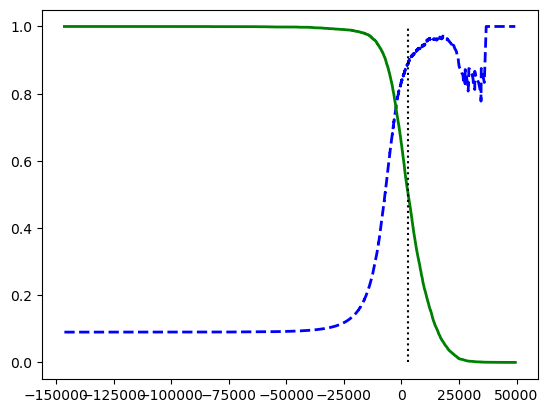

In [42]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

# 绘制的图像绿色线是Recall 蓝色线为Precision  黑色虚线为threshold 阈值

您可能会疑惑为什么在图3-5中精确度曲线比召回率曲线更加起伏不平。原因是，当您提高阈值时，精确度有时会下降（尽管通常会提高）。为了解释这个现象，可以回看图3-4，注意从中心阈值开始，将其向右移动一个数字会发生什么：精确度从4/5（80%）下降到3/4（75%）。另一方面，召回率在阈值增加时只能下降，这就是为什么它的曲线看起来更平滑的原因。

在该阈值下，精确度接近90%，召回率约为50%。选择良好的精确度/召回率权衡的另一种方法是直接绘制精确度对召回率的曲线，如图3-6所示（同样标示出该阈值位置）。

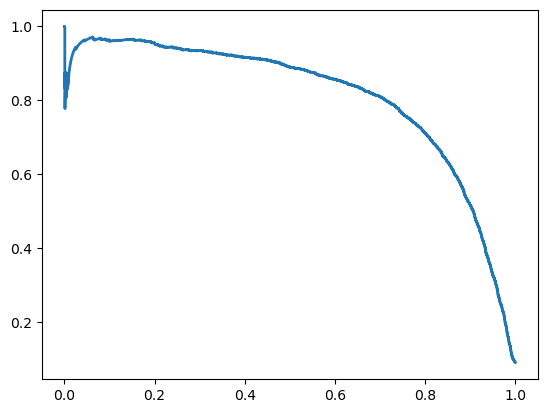

In [45]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.show()

# y轴为Precision  x轴为Recall

可以看到，精确度在召回率达到约80%时开始急剧下降。您可能会希望在下降前选择一个精确度/召回率的平衡点，例如在约60%的召回率处。当然，具体选择取决于您的项目需求。假设您决定目标为90%的精确度。可以使用第一个图来找到所需的阈值，但这种方法不够精确。另一种方法是搜索达到至少90%精确度的最低阈值。为此，您可以使用NumPy数组的 argmax() 方法，这会返回最大值的第一个索引，在这种情况下即第一个满足条件的位置。

In [46]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]

threshold_for_90_precision


3370.0194991439557

In [47]:
#要进行预测（目前是在训练集上），您可以运行以下代码，而不是调用分类器的predict（）方法：
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

#让我们来看看这些预测的准确性和召回率：
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [48]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

太好了，你有一个90%精度的分类器！正如您所看到的，创建具有您想要的任何精度的分类器是相当容易的：只需设置足够高的阈值，就完成了。但是，等等，不要这么快——如果召回率太低，高精度分类器就不是很有用！对于许多应用程序来说，48%的召回率根本就不怎么样。


> The ROC Curve   ROC曲线
> 
受试者工作特征（ROC）曲线是二分类器常用的另一种工具。它与精确度/召回率曲线非常相似，但ROC曲线是将真正例率（另一个名称是召回率）(TPR)与假正例率（FPR）进行对比。假正例率（也称为失误率）是被错误分类为正类的负类实例的比例。它等于1减去真负例率（TNR），即被正确分类为负类的负类实例的比例。TNR也称为特异性。因此，ROC曲线是将敏感性（召回率）与1-特异性进行绘制。

要绘制ROC曲线，首先使用 roc_curve() 函数计算各种阈值下的TPR和FPR。


In [49]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

然后，您可以使用Matplotlib绘制FPR与TPR的关系。下面的代码生成图3-7中的图。为了找到对应于90%精度的点，我们需要查找所需阈值的索引。由于阈值在本例中按降序排列，因此我们在第一行使用<=而不是>=：

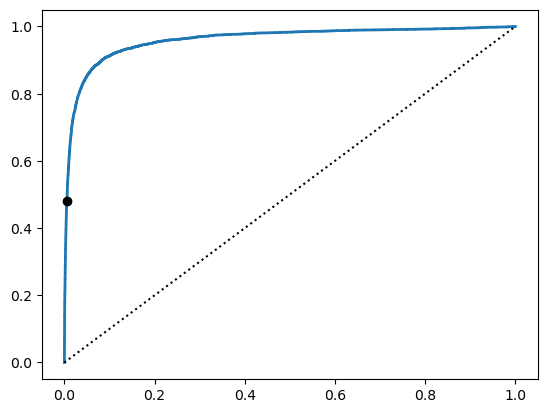

In [50]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.show()
# 蓝色实线为ROC curve  黑色点为90精度的阈值点  虚线代表纯随机分类器的ROC曲线

![](3-7.png)

在ROC曲线上同样存在一种权衡：召回率（TPR）越高，分类器产生的假正例（FPR）也会越多。虚线代表纯随机分类器的ROC曲线；一个好的分类器应尽量远离该线（朝向左上角）。

比较分类器的一种方法是计算曲线下的面积（AUC）。一个完美的分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。Scikit-Learn 提供了一个函数来估计ROC AUC。

In [51]:
# 计算曲线ROC 线下的面积，面积值越接近1越好（一个好的分类器应尽量远离虚线）
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> 如何抉择使用那个方法观察分类器表现
> 
由于ROC曲线与精确度/召回率（PR）曲线非常相似，您可能会疑惑该如何选择。经验法则是：当正类较为稀少，或您更关注假阳性而非假阴性时，优先使用PR曲线。否则，可以使用ROC曲线。例如，观察前面的ROC曲线（以及ROC AUC得分）可能会让您觉得分类器表现很好，但这主要是因为与负类（非5）相比，正类（5）数量较少。而PR曲线则更清晰地表明了分类器还有改进空间：曲线实际上可以更接近右上角（参见图3-6）。

现在让我们创建一个RandomForestClassifier，我们可以将其PR曲线和F分数与SGDClassifier进行比较：

In [52]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

precision_recall_curve() 函数需要每个实例的标签和得分，因此我们需要训练随机森林分类器并让其为每个实例分配一个得分。但由于其工作原理，RandomForestClassifier 类没有 decision_function() 方法（第7章将对此进行详细介绍）。幸运的是，它具有 predict_proba() 方法，可以为每个实例返回类别概率，我们只需将正类的概率用作得分即可，这样也能正常工作。我们可以调用 cross_val_predict() 函数，通过交叉验证训练 RandomForestClassifier 并让它预测每张图像的类别概率，如下所示：

In [54]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

#让我们看看训练集中前两张图像的类概率：
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [55]:
#第二列包含了图片数字为5的概率，所以将它传给precision_recall_curve（）function
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

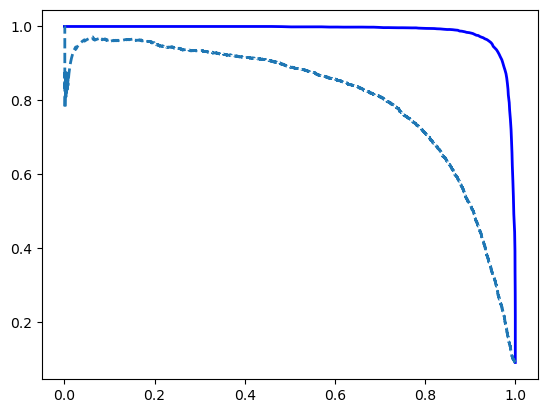

In [56]:
#现在我们可以画PR曲线了。绘制第一条PR曲线也是很有用的，这样可以比较它们
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.show()
#x轴为Recall y轴为Precision

如图所示，RandomForestClassifier的PR曲线看起来比SGDClassifier的要好得多：它更接近右上角。其F评分和ROC AUC评分也明显较好：

In [58]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [59]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

现在您知道了如何训练二元分类器、为您的任务选择适当的度量、使用交叉验证评估分类器、选择适合您需要的精度/召回率权衡，以及使用几个度量和曲线来比较不同的模型。你已经准备好去探测更多的东西，而不仅仅是5。

## Multiclass Classification 多分类

二分类器用于区分两个类别，而多分类器（也称为多项式分类器）可以区分两个以上的类别。

一些 Scikit-Learn 分类器（如 LogisticRegression、RandomForestClassifier 和 GaussianNB）能够直接处理多类问题，而其他分类器是严格的二分类器（如 SGDClassifier 和 SVC）。不过，有多种策略可以将多个二分类器组合起来进行多分类。

一种方法是为每个类别训练一个二分类器，即总共10个分类器（一个0检测器、一个1检测器、一个2检测器，依此类推），然后在分类时获取每个分类器的决策得分，选择得分最高的类别。这称为“一个对其余”（OvR）策略，或称为“一个对全部”（OvA）策略。

另一种方法是为每对类别训练一个二分类器：比如一个区分0和1的分类器、一个区分0和2的分类器、一个区分1和2的分类器，依此类推。这称为“一个对一个”（OvO）策略。若有N个类别，则需要训练N×(N−1)/2 个分类器。对于MNIST问题，这意味着需要训练45个二分类器！在分类时，将图像输入到所有45个分类器中，查看哪个类别在决斗中获胜最多。<span style="background-color:yellow">OvO 的主要优点是每个分类器只需训练它需要区分的两个类别的训练集部分</span>（举个例子“0和1”分类器的训练数据只包含类别 0 和类别 1 的样本，而不包含其他类别的数据。）。

对于一些算法（如支持向量机分类器），当训练集规模很大时，训练效率较差。对于这些算法，优先使用OvO，因为在较小的训练集上训练多个分类器比在大型训练集上训练少数分类器更快。然而，对于大多数二分类算法，OvR 是首选。

Scikit-Learn 会自动检测您何时将二分类算法用于多分类任务，并根据算法自动运行 OvR 或 OvO。让我们使用 sklearn.svm.SVC 类的支持向量机分类器来尝试这一点（参见第5章）。为了节省时间，我们只在前2000张图像上进行训练。





In [61]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])


SVC(random_state=42)

Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let’s make a prediction on an image:

In [62]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

没错！这段代码实际上进行了45次预测——每对类别进行一次预测，并选择胜出次数最多的类别。如果调用 decision_function() 方法，会看到每个实例返回10个得分——每个类别一个得分。每个类别的得分等于它在决斗中获胜的次数，加上或减去一个小的调整（最大 ±0.33），用于根据分类器的得分打破平局。(意思就是，对于X【0】这个样本，被送入到45个二分类器中，根据45个票数，得出最多的那个即为预测值)

In [63]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [64]:
class_id = some_digit_scores.argmax()
class_id

5

当训练一个分类器时，它会将目标类别的列表存储在其 classes_ 属性中，按值顺序排列。对于 MNIST 数据集来说，classes_ 数组中每个类别的索引恰好与类别本身一致（例如，索引为 5 的类别恰好是类别 “5”），但通常情况下不会如此方便。因此，您需要像这样查找类别标签：

In [65]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [66]:
svm_clf.classes_[class_id]

'5'

如果想强制使用OVO 或者 OVR   可以使用onevsonecclassifier或OneVsRestClassifier类。只需创建一个实例并将一个分类器传递给它的构造函数（它甚至不必是二进制分类器）。例如，以下代码使用基于SVC的OvR策略创建了一个多类分类器：

In [67]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [68]:
#check the number of trained classifiers:
len(ovr_clf.estimators_)

10

在多类数据集上训练SGDClassifier并使用它进行预测同样简单：

In [69]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [70]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

可以看到，分类器对其预测并不是很有信心：几乎所有得分都是非常负的，而类别 3 的得分为 +1824，类别 5 的得分也不算太低，为 -1386。当然，您会希望在多张图像上评估该分类器。由于每个类别的图像数量大致相同，准确率（accuracy）指标是合适的。像往常一样，可以使用 cross_val_score() 函数来评估模型。

In [71]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

它在所有测试折叠中都超过了85.8%。如果你使用随机分类器，你会得到10%的准确率，所以这不是一个糟糕的分数，但你仍然可以做得更好。简单地缩放输入（如第2章所述）将精度提高到89.1%以上：

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis 错误分析

如果这是一个实际项目，现在您将按照机器学习项目清单中的步骤（见附录A）继续进行。您会探索数据准备选项，尝试多种模型，筛选出表现最好的模型，并使用 GridSearchCV 对其超参数进行微调，同时尽可能自动化流程。在这里，我们假设您已经找到一个有前途的模型，并希望找到改进的方法。改进的一种方式是分析模型错误的类型。

首先，查看混淆矩阵。为此，首先需要使用 cross_val_predict() 函数生成预测结果；然后将标签和预测结果传递给 confusion_matrix() 函数，和之前的做法相同。不过，由于现在有10个类别而不是2个，混淆矩阵将包含大量数字，可能难以阅读。

使用彩色混淆矩阵图表更容易分析。要绘制此图表，可以使用 ConfusionMatrixDisplay.from_predictions() 函数，如下所示：

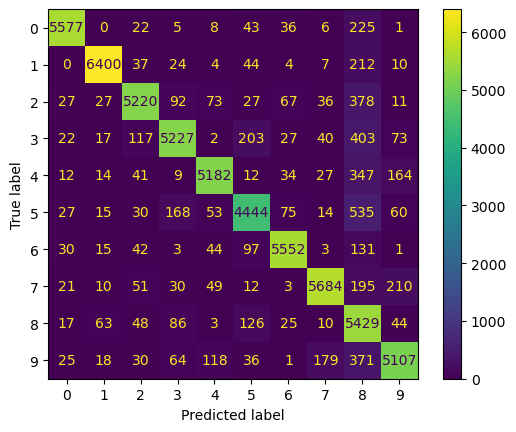

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()     #X_train:  6万张数字图片

大多数图像位于主对角线上，表示它们被正确分类。注意，第5行第5列对角线上的单元格比其他数字略暗一些。这可能是因为模型在数字5上犯了更多错误，或者数据集中5的数量比其他数字少。这就是为什么归一化混淆矩阵非常重要，通过将每个值除以对应（真实）类别中的图像总数（即按行的总和进行归一化）。只需设置 normalize="true" 即可实现此操作。我们还可以指定 values_format=".0%" 参数来显示不含小数的百分比。以下代码生成了下方图表：

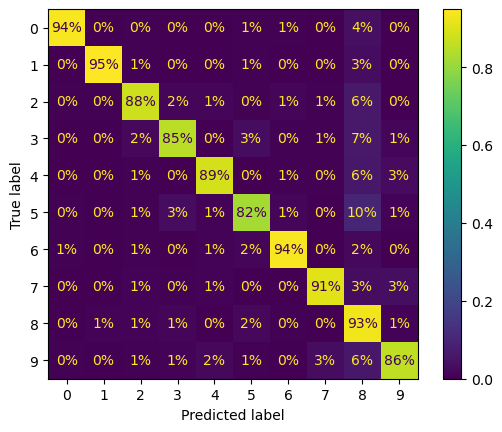

In [75]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%") 
plt.show()

现在，我们可以轻松看到只有82%的数字5图像被正确分类。模型在数字5图像上的最常见错误是将其误分类为8：这种情况发生在所有5中占10%。但是，只有2%的数字8被误分类为5；混淆矩阵通常不是对称的！如果仔细观察，会发现许多数字被误分类为8，但在这个图表中不太明显。如果希望让这些错误更加突出，可以尝试将正确预测的权重设为零。以下代码正是实现了这一点，并生成了下方的图表：

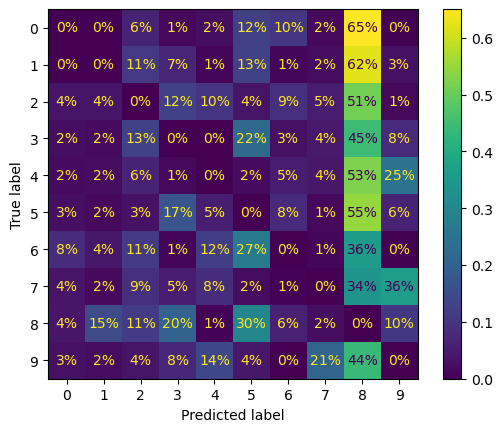

In [76]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight,
normalize="true", values_format=".0%")
plt.show()

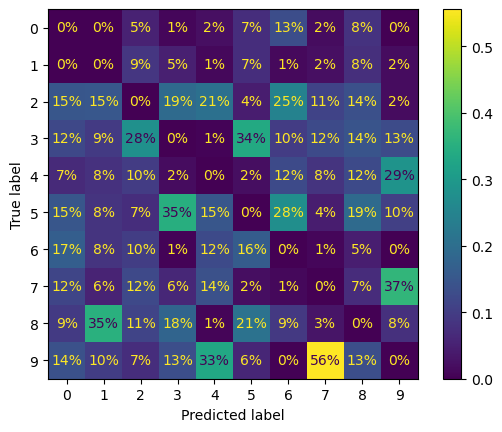

In [77]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight,
normalize="pred", values_format=".0%")
plt.show()

现在，您可以更清楚地看到分类器所犯的错误类型。类别8的列现在非常亮，这表明许多图像被错误分类为8。事实上，对于几乎所有类别，这是最常见的误分类。但要小心解释图中的百分比：记住，我们已排除了正确的预测。例如，第7行第9列的36%并不意味着所有7的图像中有36%被误分类为9，而是指模型在7的图像上犯的错误中，有36%被误分类为9。实际上，只有3%的7的图像被误分类为9，如上图所示。

还可以按列而不是按行对混淆矩阵进行归一化：如果设置 normalize="pred"，可以得到图3-10右侧的图表。例如，可以看到被误分类为7的56%实际上是9。

分析混淆矩阵通常可以为改进分类器提供洞见。观察这些图表，似乎应集中精力减少误分类为8的情况。例如，可以尝试收集更多类似8（但不是8）的数字的训练数据，以便分类器能够学习将它们与真实的8区分开来。或者可以设计新的特征帮助分类器，例如编写一个算法来计算封闭环的数量（例如，8有两个，6有一个，5没有）。还可以预处理图像（例如，使用 Scikit-Image、Pillow 或 OpenCV），使某些模式（如封闭环）更加突出。

分析个别错误也是理解分类器行为和失败原因的好方法。例如，让我们以混淆矩阵的样式绘制3和5的示例,如下图3-11：

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

![](3-11.png)

正如您所见，分类器错误分类的一些数字（即左下角和右上角的块）书写得非常糟糕，以至于即使是人类也难以分辨它们。然而，大多数被误分类的图像在我们看来却是明显的错误。或许很难理解分类器为什么会犯这些错误，但请记住，人类大脑是一个出色的模式识别系统，我们的视觉系统在信息进入意识之前已经进行了大量复杂的预处理。因此，这项任务看似简单并不意味着它真的容易。回想一下我们使用的 SGDClassifier 是一个简单的线性模型：它只是为每个像素按类别分配一个权重，当看到新图像时，将加权像素强度相加以得到每个类别的分数。由于数字3和5仅在少数像素上有所不同，因此该模型容易将它们混淆。

数字3和5的主要区别在于连接顶部线条与底部弧线的小线条位置。如果稍微向左移动3的连接部分，分类器可能会将其识别为5，反之亦然。换句话说，这个分类器对图像的平移和旋转非常敏感。减少3/5混淆的一种方法是预处理图像，确保它们居中且没有过多旋转。然而，这并不容易，因为需要预测每张图像的正确旋转角度。一种更简单的方法是扩充训练集，添加略微平移和旋转的训练图像变体。这将迫使模型学习对这些变化更加宽容。此方法称为<span style="background-color:yellow">数据增强</span>（将在第14章讨论；另见本章末尾的练习2）。


## Multilabel Classification  多标签分类

到目前为止，每个实例总是被分配到一个类别中。但在某些情况下，您可能希望分类器为每个实例输出多个类别。想象一个面部识别分类器：如果在同一张图片中识别出多个不同的人物，它该怎么办？它应该为每个识别到的人物附上一个标签。假设分类器已经训练成可以识别三张脸：Alice、Bob 和 Charlie。那么当分类器看到 Alice 和 Charlie 的照片时，它应该输出 [True, False, True]（表示“识别到 Alice，未识别到 Bob，识别到 Charlie”）。这种输出多个二值标签的分类系统称为多标签分类系统。

我们暂时不讨论面部识别，但可以通过一个更简单的例子来说明多标签分类的概念：

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier  

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

NameError: name 'y_train' is not defined

这段代码创建了一个 y_multilabel 数组，其中每张数字图像包含两个目标标签：第一个标签表示该数字是否为“大”（即是否为7、8或9），第二个标签表示该数字是否为奇数。然后，代码创建了一个支持多标签分类的 KNeighborsClassifier 实例（并非所有分类器都支持多标签分类），并使用这个多目标标签数组来训练模型。现在您可以进行预测，注意到输出将包含两个标签：

In [79]:
knn_clf.predict([some_digit])

array([[False,  True]])

它正确地预测了！数字5确实不是“大”（False）且是奇数（True）。评估多标签分类器有很多方法，选择合适的评估指标取决于您的项目需求。一个常见的方法是为每个标签计算 F 分数（或前面讨论的其他二分类指标），然后计算平均得分。以下代码计算了所有标签的平均 F 分数：


In [80]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

这种方法假设所有标签的重要性相同，但这可能并不符合实际需求。尤其是，如果您有更多的Alice图片而少量的Bob或Charlie图片，您可能希望对Alice图片的分类得分赋予更大的权重。一种简单的方法是将每个标签的权重设为其支持度（即具有该目标标签的实例数量）。为此，只需在调用 f1_score() 函数时设置 average="weighted" 即可。

如果您想使用不原生支持多标签分类的分类器（例如SVC），可以使用一种策略，即为每个标签训练一个模型。然而，这种策略可能难以捕捉标签之间的依赖关系。例如，较大的数字（7、8或9）比偶数的可能性高出一倍，但“奇数”标签的分类器并不知道“较大”标签的分类器预测结果。为了解决此问题，可以将模型组织成一个链：当模型进行预测时，它会使用输入特征加上链中之前模型的所有预测结果。

好消息是Scikit-Learn中有一个 ChainClassifier 类正好实现了这一点！默认情况下，它在训练时使用真实标签，给每个模型提供与其在链中的位置对应的适当标签。但如果设置 cv 超参数，它将使用交叉验证为训练集中的每个实例生成“干净”的（样本外）预测，然后使用这些预测来训练链中后续的所有模型。以下示例展示了如何使用交叉验证策略创建和训练 ChainClassifier。与前面一样，我们只使用训练集中的前2000张图像以加快速度：

In [81]:
from sklearn.multioutput import ClassifierChain  
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

Now we can use this ChainClassifier to make predictions:

In [82]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification  多输出多类别分类

我们将在这里讨论的最后一种分类任务称为多输出-多类别分类（或简称为多输出分类）。这是多标签分类的扩展，其中每个标签可以是多类别的（即，标签可以有两个以上的可能值）。

为说明这一点，让我们构建一个从图像中去除噪声的系统。该系统将接收带噪声的数字图像作为输入，并（希望）输出一张干净的数字图像，表示为像素强度的数组，就像MNIST图像一样。请注意，分类器的输出是多标签的（每个像素一个标签），且每个标签可以有多个值（像素强度范围为0到255）。因此，这是一个多输出分类系统的示例。

在一些情况下，分类和回归之间的界限并不十分清晰，例如在这个例子中。可以说，预测像素强度更接近于回归而非分类。此外，多输出系统不仅限于分类任务；您甚至可以有一个系统为每个实例输出多个标签，包括类别标签和数值标签。


让我们首先创建训练集和测试集，方法是获取MNIST图像并使用NumPy的randint（）函数向其像素强度添加噪声。目标图像将是原始图像：

In [83]:
np.random.seed(42) # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

让我们看一下测试集的第一张图像（图3-12）。是的，我们在偷看测试数据，所以你现在应该皱眉了。

![](3-12.png)

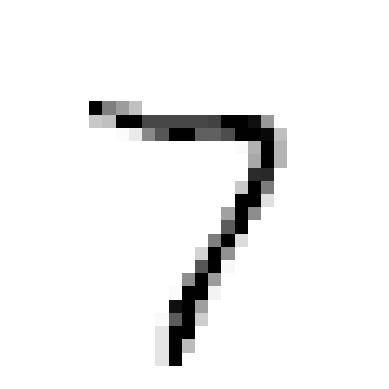

In [84]:
#左边是带噪声的输入图像，右边是干净的目标图像。现在让我们训练分类器，让它清理这个图像

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

看起来离目标够近了！我们的分类之旅到此结束。现在您已经了解了如何为分类任务选择合适的指标、选择适当的精度/召回率权衡、比较分类器，以及如何为各种任务构建良好的分类系统。在接下来的章节中，你将了解所有这些你一直在使用的机器学习模型是如何工作的。